<a href="https://colab.research.google.com/github/gohzhihwee/stuffs/blob/main/portfolio_techstocks_ZH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U kaleido

The following program used to calculate asset and portfolio statistics was created by Steven Medvetz (https://github.com/StevenMedvetz/stock-analysis/tree/main). I use this program to generate plots of the closing prices as well as calculate the mean return and standard deviation from the mean for each stock in the portfolio, as well as the correlation and covariance matrices between the stocks in the portfolio. Subsequently, I write additional functions to calculate the skewness and kurtosis for each stock as well as the portfolio. As this is a cryptocurrency portfolio notebook, all stock tickers are of cryptocurrencies. Data is taken from the Yahoo Finance website 'yfinance'.

In [2]:
import numpy as np
import yfinance as yf
from datetime import datetime
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import random
pio.renderers.default = "png"

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
class Asset:
    def __init__(self, ticker, start_date, end_date = datetime.today().strftime('%Y-%m-%d')):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date

    def get_data(self):
        df = yf.download(self.ticker, start = self.start_date, end = self.end_date)
        return df

    def simple_returns(self, adj = False, cum = False):
        df = self.get_data()
        if adj:
            simple_returns = df["Adj Close"].pct_change().dropna()
        else:
            simple_returns = df["Close"].pct_change().dropna()
        if cum:
            simple_returns = (1 + simple_returns).cumprod() - 1
        return simple_returns

    def log_returns(self, adj = False, cum = False):
        simple_returns = self.simple_returns(adj, cum)
        log_returns = np.log(1+simple_returns)
        return log_returns

    def std(self, adj = False, crypto = False):
        returns = self.simple_returns(adj).mul(100)
        if crypto:
            trading_days = 365
        else:
            trading_days  = 252
        std = returns.describe().T.loc["std"]
        std = std*np.sqrt(trading_days)
        return std

    def mean_return(self, adj = False, crypto = False, template = 'plotly_dark'):
        returns = self.simple_returns(adj).mul(100)
        if crypto:
            trading_days = 365
        else:
            trading_days  = 252
        mean = returns.describe().T.loc["mean"]
        mean = mean*trading_days # Multiply by number of trading days
        return mean

    def returns_plot(self, adj = False, cum = False, log = False, template = 'plotly_dark'):
        returns = self.simple_returns(adj, cum).mul(100)
        if log:
            returns = self.log_returns(adj, cum).mul(100)
        try:
            returns = returns.to_frame()
        except:
            pass

        returns = returns.rename(columns={'Close': 'Returns'})
        fig = px.line(returns, template = template)
        fig.update_traces(hovertemplate='%{y:.2f}%')
        fig.update_layout(
            showlegend = True,
            legend = dict(title = None, font = dict(size = 16)),
            title={
                'y':0.95,
                'x':0.5,
                'text': f"{self.ticker} Daily Returns",
                'font': {'size': 24},

                'xanchor': 'center',
                'yanchor': 'top'},
            hovermode = "x unified",
            xaxis_title = "Date",
            yaxis_title = "% Returns")

        fig.show()
        return returns

    def close_plot(self, adj = False, normalize = False, template = 'plotly_dark'):
        df = self.get_data()

        if adj:
            df["CLose"] = df["Adj Close"]
            title = f"{self.ticker} Adjusted Closing Price"
        else:
            title = f"{self.ticker} Closing Price"

        if normalize:
            df["Close"] = df["Close"].div(df["Close"].iloc[0]) #Normalizes data
            fig = px.line(df["Close"],
                          x = df.index,
                          y = df["Close"],
                          title = "Normalized " + title,
                          template = template) # Plotting Normalized closing data
            fig.update_traces(hovertemplate='Price: $%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                'y':0.9,
                'x':0.5,
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = "Normalized " + title + " (USD)"
                )
            fig.show()
        else:

            fig = px.line(df["Close"],
                          x = df.index,
                          y = df["Close"],
                          title = title,
                          template = template) # Plotting Normalized closing data
            fig.update_traces(hovertemplate='Price: $%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                'y':0.9,
                'x':0.5,
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = "Closing Price (USD)"
                )
            fig.show()


    def candlestick(self, sma1 = 0, sma2 = 0, template = 'plotly_dark'):

        ticker = Asset(self.ticker, self.start_date)
        df = ticker.get_data()

        fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02, row_heights=[0.7, 0.3])
        fig.add_trace(go.Candlestick(x=df.index,
                                      open=df['Open'],
                                      high=df['High'],
                                      low=df['Low'],
                                      close=df['Close'],
                                      name='candlestick'),

                      row=1, col=1)
        fig.update_traces(increasing_line_width = 1.5,
                          decreasing_line_width = 1.5
                         )
        if sma1 > 0:
            fig.add_trace(go.Scatter(x=df.index, y=df['Close'].rolling(window=sma1).mean(),
                                      name=f'{sma1}-day moving average', line=dict(color='lightblue', width = 1)),
                          row=1, col=1)
        if sma2 > 0:
            fig.add_trace(go.Scatter(x=df.index, y=df['Close'].rolling(window=sma2).mean(),
                                      name=f'{sma2}-day moving average', line=dict(color='red', width = 1)),
                          row=1, col=1)

        fig.add_trace(go.Bar(x=df.index,
                             y=df['Volume'],
                             name='volume'),
                      row=2, col=1)

        fig.update_layout(
                          title={
                          'text': f'{self.ticker} Candlestick Chart with Volume',
                          'y':0.9,
                          'x':0.5,
                          'font': {'size': 24},
                          'xanchor': 'center',
                          'yanchor': 'top',},
                          xaxis_rangeslider_visible=False,
                          xaxis_title='Date',
                          yaxis_title='Price (USD)',
                          hovermode = "x unified",
                          bargap=0,
                          bargroupgap=0,
                          template = template)
        fig.update_xaxes(title_text='', row=1, col=1, showgrid=False)
        fig.update_xaxes(title='Date', row=2, col=1)
        fig.update_yaxes(title='Volume',row=2,col=1)

        fig.show()

In [4]:
class Portfolio:
    def __init__(self, assets, start_date, weights = None, end_date = datetime.today().strftime('%Y-%m-%d')):
        self.assets = assets
        self.start_date = start_date
        self.end_date = end_date

        if weights is not None:
            self.weights = np.array(weights)
        else:
            self.weights = self.generate_random_weights()
    def generate_random_weights(self):
    # Generate random weights that add up to 1 and round to 1 digit
        weights = [round(random.random(), 1) for _ in range(len(self.assets))]
        total_weight = sum(weights)
        weights = np.array([round(weight / total_weight, 1) for weight in weights])
        print(weights)
        return weights



    # Data gather using yfinance
    def get_data(self):
        df = yf.download(self.assets, start = self.start_date, end = self.end_date)
        return df

    # Plot the closing price data
    def close_plot(self, adj = False, normalize = False, template = 'plotly_dark'):
        df = self.get_data()
        if adj:
            close = df.loc[:,"Adj Close"].copy()
            title = "Adjusted Closing Prices"
        else:
            close = df.loc[:,"Close"].copy()
            title = "Closing Prices"

        if normalize:
            normclose = close.div(close.iloc[0]) #Normalizes data

            normclose = normclose.to_frame()
            fig = px.line(normclose,
                          x = normclose.index,
                          y = normclose.columns,
                          title = "Normalized " + title,
                          template = template) # Plotting Normalized closing data
            fig.update_traces(hovertemplate='%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                'y':0.9,
                'x':0.5,
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = "Normalized " + title + " (USD)"
                )
            fig.show()
        else:


            fig = px.line(close,
                          x = close.index,
                          y = close.columns,
                          title = title,
                          template = template) # Plotting Normalized closing data
            fig.update_traces(hovertemplate='%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                'y':0.9,
                'x':0.5,
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = title +  " (USD)"
                )
            fig.show()


    def simple_returns(self, adj = False, cum = False):
        df = self.get_data()
        if adj:
            simple_returns = df["Adj Close"].pct_change().dropna()
        else:
            simple_returns = df["Close"].pct_change().dropna()
        if cum:
            simple_returns = (1 + simple_returns).cumprod() - 1
        return simple_returns

    def log_returns(self, adj = False, cum = False):
        simple_returns = self.simple_returns(adj, cum)
        log_returns = np.log(1+simple_returns)
        return log_returns


    def portfolio_returns(self, adj = False, cum = False):
        returns = self.simple_returns(adj, cum)
        portfolio_returns = (returns*self.weights).sum(axis=1)
        return portfolio_returns

    def returns_plot(self, port = False, benchmark = False, adj = False, cum = False, log = False, template = 'plotly_dark'):
        returns = self.simple_returns(adj, cum).mul(100)
        if log:
            returns = self.log_returns(adj, cum).mul(100)
        fig = px.line(returns, template = template)
        fig.update_traces(hovertemplate='%{y}')
        fig.update_layout(
            legend = dict(title = None, font = dict(size = 16)),
            title={
                'y':0.95,
                'x':0.5,
                'text': "Asset Returns",
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
            hovermode = "x unified",
            xaxis_title = "Date",
            yaxis_title = "% Returns")

        if port:
            portfolio_returns = self.portfolio_returns(adj, cum)
            fig = px.line(portfolio_returns, template = template)
            fig.update_traces(name = 'Returns',hovertemplate='%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                    'y':0.95,
                    'x':0.5,
                    'text': "Portfolio Returns",
                    'font': {'size': 24},
                    'xanchor': 'center',
                    'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = "% Returns")

        fig.show()

    def cov_matrix(self, plot = False, cum = False, template = 'plotly_dark'):
        returns = self.simple_returns()
        if cum:
            returns = self.simple_returns(cum)
        cov_matrix = returns.cov()

        if plot:
            fig = px.imshow(cov_matrix, text_auto=True, color_continuous_scale='tempo', template = template, title = "Covariance Matrix")
            fig.update_layout(
                legend = dict(title = None),
                title={
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'}
                )
            fig.show()
        return cov_matrix

    def corr_matrix(self, plot = False, cum = False, template = 'plotly_dark'):
        returns = self.simple_returns()
        if cum:
            returns = self.simple_returns(cum)
        corr_matrix = returns.corr()
        if plot:
            fig = px.imshow(corr_matrix, text_auto=True, color_continuous_scale='tempo', template = template, title = "Correlation Matrix")
            fig.update_layout(
                legend = dict(title = None),
                title={
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'}
                )
            fig.show()
        return corr_matrix

        #Standard Deviation of Portfolio w/ Optional Crypto Arg
    def port_std(self, crypto = False):
        if crypto:
            trading_days = 365
        else:
            trading_days  = 252

        cov_matrix = self.cov_matrix()
        port_variance = np.dot(self.weights.T, np.dot(cov_matrix, self.weights))
        port_std = np.sqrt(port_variance) * np.sqrt(trading_days)


        return port_std

    def risk_return(self, adj = False, crypto = False, template = 'plotly_dark'):
        returns = self.simple_returns(adj).mul(100)
        if crypto:
            trading_days = 365
        else:
            trading_days  = 252
        summary = returns.describe().T.loc[:,["mean","std"]]
        summary["mean"] = round(summary["mean"]*trading_days,2) # Multiply by number of trading days
        summary["std"]  = round(summary["std"]*np.sqrt(trading_days),2)
        summary.rename(columns = {'mean':'% Return', 'std':'Risk'}, inplace = True)
        fig = px.scatter(summary,
                         x = 'Risk',
                         y = '% Return',
                         title = "Annual Risk / Return",
                         text = summary.index,
                         template = template)
        fig.update_traces(hovertemplate='Risk: %{x}<br>Return: %{y}')
        fig.update_traces(marker={'size': 15},
                          textposition='top center',
                          hoverlabel=dict(font=dict(size=15) ))
        fig.update_layout(
            legend = dict(title = None),
            title={
            'y':0.9,
            'x':0.5,
            'font': {'size': 24},
            'xanchor': 'center',
            'yanchor': 'top',},
            xaxis = dict(title = dict(font = dict(size = 20))),
            yaxis = dict(title = dict(font = dict(size = 20)))
            )
        fig.show()

    def pie_plot(self, template = 'plotly_dark'):
        data = pd.DataFrame({"Assets": self.assets,
                             "Weights": self.weights})
        fig=go.Figure(go.Pie(labels=data['Assets'],
                                 values=data['Weights'],
                                 name = "",
                                 textinfo = 'label + percent'))
        fig.update_layout(template = template)
        fig.update_traces(hovertemplate='%{label}: %{percent}')
        fig.show()

In [5]:
tickers = ['MSFT', 'GOOGL', 'BABA', 'BIDU', 'EBAY', 'SAP', 'CRM', 'ADBE', 'CTSH', 'INFY']
weights = [0.1 for i in range(len(tickers))]
start_date = '2022-02-10'
pf = Portfolio(tickers, start_date, weights)

[*********************100%%**********************]  10 of 10 completed


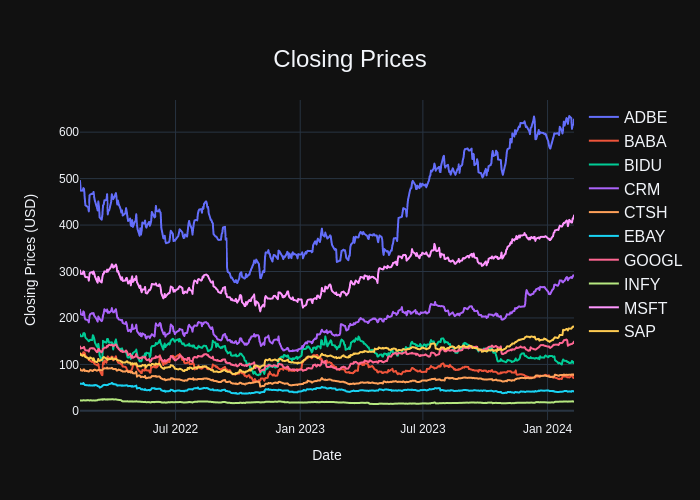

In [6]:
pf.close_plot()

In [7]:
pf.corr_matrix()

[*********************100%%**********************]  10 of 10 completed


Ticker,ADBE,BABA,BIDU,CRM,CTSH,EBAY,GOOGL,INFY,MSFT,SAP
Ticker,,,,,,,,,,
ADBE,1.000000,0.306792,0.366883,0.669342,0.481451,0.480116,0.644935,0.396560,0.706645,0.591689
BABA,0.306792,1.000000,0.813819,0.320519,0.298938,0.331496,0.329463,0.274711,0.276728,0.338039
BIDU,0.366883,0.813819,1.000000,0.353637,0.301407,0.344892,0.400941,0.248220,0.355612,0.355867
CRM,0.669342,0.320519,0.353637,1.000000,0.503900,0.471226,0.579431,0.415311,0.631413,0.548366
CTSH,0.481451,0.298938,0.301407,0.503900,1.000000,0.536162,0.497376,0.513876,0.514479,0.503714
EBAY,0.480116,0.331496,0.344892,0.471226,0.536162,1.000000,0.511816,0.363147,0.495376,0.460264
GOOGL,0.644935,0.329463,0.400941,0.579431,0.497376,0.511816,1.000000,0.417907,0.725996,0.543039
INFY,0.396560,0.274711,0.248220,0.415311,0.513876,0.363147,0.417907,1.000000,0.442167,0.495894
MSFT,0.706645,0.276728,0.355612,0.631413,0.514479,0.495376,0.725996,0.442167,1.000000,0.586229


In [8]:
pf.cov_matrix()

[*********************100%%**********************]  10 of 10 completed


Ticker,ADBE,BABA,BIDU,CRM,CTSH,EBAY,GOOGL,INFY,MSFT,SAP
Ticker,,,,,,,,,,
ADBE,0.000583,0.000278,0.000336,0.000392,0.000214,0.000238,0.000337,0.000162,0.000323,0.000250
BABA,0.000278,0.001409,0.001159,0.000292,0.000206,0.000256,0.000268,0.000174,0.000197,0.000222
BIDU,0.000336,0.001159,0.001440,0.000325,0.000210,0.000269,0.000330,0.000159,0.000256,0.000236
CRM,0.000392,0.000292,0.000325,0.000587,0.000225,0.000235,0.000304,0.000170,0.000290,0.000232
CTSH,0.000214,0.000206,0.000210,0.000225,0.000338,0.000203,0.000198,0.000160,0.000179,0.000162
EBAY,0.000238,0.000256,0.000269,0.000235,0.000203,0.000423,0.000228,0.000126,0.000193,0.000166
GOOGL,0.000337,0.000268,0.000330,0.000304,0.000198,0.000228,0.000470,0.000153,0.000298,0.000206
INFY,0.000162,0.000174,0.000159,0.000170,0.000160,0.000126,0.000153,0.000286,0.000142,0.000147
MSFT,0.000323,0.000197,0.000256,0.000290,0.000179,0.000193,0.000298,0.000142,0.000359,0.000194


In [9]:
asset_dict = {}
mret_dict = {}
sd_dict = {}
for tf in tickers:
  asset_dict[f'{tf}'] = Asset(tf, start_date)
  mret_dict[f'{tf}'] = asset_dict[f'{tf}'].mean_return()
  sd_dict[f'{tf}'] = asset_dict[f'{tf}'].std()
mret_dict

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

{'MSFT': 21.107756599228065,
 'GOOGL': 9.556504846109629,
 'BABA': -10.370128503677876,
 'BIDU': -4.999259220351519,
 'EBAY': -11.054713756321352,
 'SAP': 23.06576784008604,
 'CRM': 22.000163552204324,
 'ADBE': 19.331163770424588,
 'CTSH': -3.5875858670922125,
 'INFY': -3.0246632048352953}

In [10]:
sd_dict

{'MSFT': 30.090789554346763,
 'GOOGL': 34.398562087313735,
 'BABA': 59.593412856193204,
 'BIDU': 60.231041210859985,
 'EBAY': 32.66373275634435,
 'SAP': 27.750925649990297,
 'CRM': 38.4719271480756,
 'ADBE': 38.31826573980604,
 'CTSH': 29.197237676895327,
 'INFY': 26.84176365010659}

In [11]:
#Narrow down stock selection to top 3 stocks with highest mean returns during
#this period (the assumption is that the portfolio was created on 2024-01-10)
x=list(mret_dict.values())
top3 = []
x.sort(reverse=True)
x=x[:3]
for i in x:
    for j in mret_dict.keys():
        if(mret_dict[j]==i):
            print(str(j)+" : "+str(mret_dict[j]))
            top3.append(j)

SAP : 23.06576784008604
CRM : 22.000163552204324
MSFT : 21.107756599228065


In [12]:
#Now redo portfolio to only include top 3 cryptocurrency shares
weights = [x[e]/sum(x) for e in range(len(x))]
start_date = '2024-01-10'
pf = Portfolio(top3, start_date, weights)

In [13]:
weights

[0.348564037159942, 0.3324608952583104, 0.3189750675817475]

[*********************100%%**********************]  3 of 3 completed


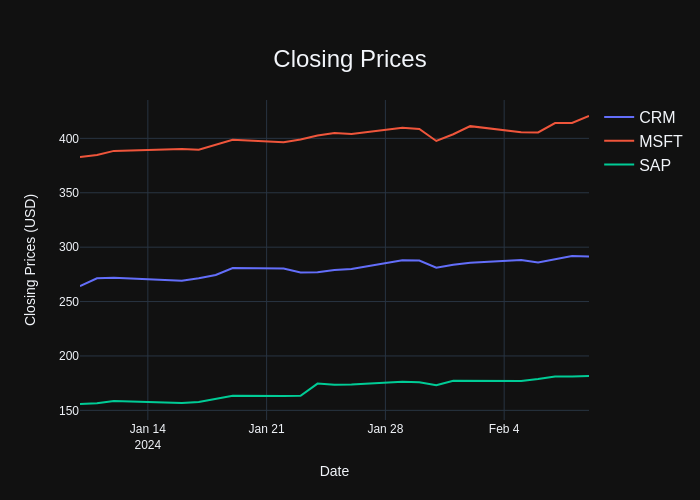

In [14]:
pf.close_plot()

In [15]:
pf.corr_matrix()

[*********************100%%**********************]  3 of 3 completed


Ticker,CRM,MSFT,SAP
Ticker,,,
CRM,1.000000,0.487705,0.280544
MSFT,0.487705,1.000000,0.435879
SAP,0.280544,0.435879,1.000000


In [16]:
pf.cov_matrix()

[*********************100%%**********************]  3 of 3 completed


Ticker,CRM,MSFT,SAP
Ticker,,,
CRM,0.000160,0.000070,0.000061
MSFT,0.000070,0.000129,0.000085
SAP,0.000061,0.000085,0.000296


In [17]:
sdev_pf = pf.port_std()
sdev_pf

[*********************100%%**********************]  3 of 3 completed


0.16761296114359187

In [18]:
returns = pf.portfolio_returns()
returns

[*********************100%%**********************]  3 of 3 completed


Date
2024-01-11    0.012555
2024-01-12    0.008163
2024-01-16   -0.005432
2024-01-17    0.004185
2024-01-18    0.012991
2024-01-19    0.018210
2024-01-22   -0.002989
2024-01-23   -0.002054
2024-01-24    0.025114
2024-01-25    0.002477
2024-01-26    0.000806
2024-01-29    0.019512
2024-01-30   -0.002178
2024-01-31   -0.021776
2024-02-01    0.016137
2024-02-02    0.008122
2024-02-05   -0.001550
2024-02-06    0.000263
2024-02-07    0.014953
2024-02-08    0.003766
2024-02-09    0.005081
dtype: float64

In [19]:
total_return_portfolio = sum(returns)
total_return_portfolio

0.11635602761870283

In [20]:
mean_ret = total_return_portfolio/len(returns)
mean_ret

0.00554076321993823

In [21]:
asset_dict = {}
mret_dict = {}
sd_dict = {}
for tf in top3:
  asset_dict[f'{tf}'] = Asset(tf, start_date)
  mret_dict[f'{tf}'] = asset_dict[f'{tf}'].mean_return()
  sd_dict[f'{tf}'] = asset_dict[f'{tf}'].std()
mret_dict

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'SAP': 187.3495790428915,
 'CRM': 119.67892763188942,
 'MSFT': 114.75520541397434}

In [22]:
sd_dict

{'SAP': 27.29107357512286,
 'CRM': 20.071162414266222,
 'MSFT': 17.997926094515208}

In [23]:
#Calculate Fisher-Pearson sample skewness coefficient and kurtosis for each
#stock's returns
return_dict = {}
sum_ctr = 0
kurt_ctr = 0
skew_dict, kurt_dict = {}, {}
for tf in top3:
  mean = 0
  return_dict[f'{tf}'] = asset_dict[f'{tf}'].simple_returns()
  mean = sum(return_dict[f'{tf}'])/len(return_dict[f'{tf}'])
  for j in range(len(return_dict[f'{tf}'])):
    sum_ctr += (return_dict[f'{tf}'][j] - mean)**3
    kurt_ctr += (return_dict[f'{tf}'][j] - mean)**4
  skew_dict[f'{tf}'] = np.sqrt(len(return_dict[f'{tf}'])*(len(return_dict[f'{tf}']) - 1))/((len(return_dict[f'{tf}']) - 2)) *(sum_ctr/(len(return_dict[f'{tf}'])*(sd_dict[f'{tf}']**3)))
  kurt_dict[f'{tf}'] = kurt_ctr/(len(return_dict[f'{tf}'])*(sd_dict[f'{tf}']**4))
skew_dict

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'SAP': 5.398608946613522e-10,
 'CRM': 1.3520234607663032e-09,
 'MSFT': 1.632398909684827e-09}

In [24]:
kurt_dict

{'SAP': 1.258649523469138e-12,
 'CRM': 4.733099407674724e-12,
 'MSFT': 7.895740318404736e-12}

In [25]:
#Calculate entire portfolio return skewness and kurtosis
sum_returns = 0
sum_ctr, kurt_ctr = 0, 0
for tf in top3:
  sum_returns += return_dict[f'{tf}']
mean = sum(sum_returns)/len(sum_returns)
for j in range(len(sum_returns)):
  sum_ctr += (sum_returns[j] - mean)**3
  kurt_ctr += (sum_returns[j] - mean)**4
skew = np.sqrt(len(sum_returns)*(len(sum_returns) - 1))/((len(sum_returns) - 2)) * (sum_ctr/(len(sum_returns)*(sdev_pf**3)))
kurt = sum_ctr/(len(sum_returns)*(sdev_pf**4))

In [26]:
kurt

-0.012525272075568207

In [27]:
skew

-0.002264466036517037